In [49]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy

def display_slice(container, direction, title, cmap, minmax):
    
        
    def get_slice_3D(x):
        
        if direction == 0:
            img = container[x]
        elif direction == 1:
            img = container[:,x,:]
        elif direction == 2:
            img = container[:,:,x]
        
        fig = plt.figure()
        gs = gridspec.GridSpec(1, 2, figure=fig, width_ratios=(1,.05))
        # image
        ax = fig.add_subplot(gs[0, 0])
        aximg = ax.imshow(img, cmap=cmap)
        aximg.set_clim(minmax)
        ax.set_title(title + " {}".format(x))
        # colorbar
        ax = fig.add_subplot(gs[0, 1])
        plt.colorbar(aximg, cax=ax)
        plt.tight_layout()
        plt.show(fig)
        
    return get_slice_3D
    
def islicer(data, direction, title="", slice_number=None, cmap='gnuplot_n', minmax=None):
    '''Creates an interactive integer slider that slices a 3D volume along direction
    
    :param data: DataContainer or numpy array
    :param direction: slice direction, int, should be 0,1,2 or the axis label
    :param title: optional title for the display
    '''
    
    if hasattr(data, "as_array"):
        container = data.as_array()
        if not isinstance (direction, int):
            if direction in data.dimension_labels.values():
                direction = data.get_dimension_axis(direction)
    elif isinstance (data, numpy.ndarray):
        container = data
        
    if slice_number is None:
        slice_number = data.shape[direction]/2
    slider = widgets.IntSlider(min=0, max=data.shape[direction]-1, step=1, 
                             value=slice_number, continuous_update=False)

    if minmax is None:
        amax = container.max()
        amin = container.min()
    else:
        amin = min(minmax)
        amax = max(minmax)
    
    interact(display_slice(container, 
                           direction, 
                           title=title, 
                           cmap=cmap, 
                           minmax=(amin, amax)),
             x=slider);
    return slider
    

def link_islicer(*args):
    '''links islicers IntSlider widgets'''
    linked = [(widg, 'value') for widg in args]
    # link pair-wise
    pairs = [(linked[i+1],linked[i]) for i in range(len(linked)-1)]
    for pair in pairs:
        widgets.link(*pair)


In [50]:
#%% Initial imports etc
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
from sirf import STIR as pet

from sirf.Utilities import examples_data_path
from ccpi.optimisation.algorithms import CGLS, PDHG, FISTA
from ccpi.optimisation.operators import BlockOperator, LinearOperator
from ccpi.optimisation.functions import KullbackLeibler, IndicatorBox, FunctionOperatorComposition, BlockFunction, MixedL21Norm , ZeroFunction   
from ccpi.framework import ImageData
from ccpi.plugins.regularisers import FGP_TV#, FGP_dTV
setattr(FGP_TV, 'convex_conjugate', lambda self,x: 0.0)

%matplotlib inline

class ChangeSign(object):
    def __init__(self):
        pass
    
    @staticmethod
    def get_instance(class_name, *args,**kwargs):
        
        setattr(class_name, '__call__', ChangeSign.KL_call)
        setattr(class_name, 'gradient', ChangeSign.KL_gradient)
        setattr(class_name, 'proximal_conjugate', ChangeSign.KL_proximal_conjugate)
        
        instance = class_name(*args, **kwargs)
        return instance

    ### Few fixes for common interface
    @staticmethod
    def KL_call(self, x):
        return - self.get_value(x)
    @staticmethod
    def KL_gradient(self, image, subset = -1, out = None):

        assert_validity(image, pet.ImageData)
        grad = pet.ImageData()
        grad.handle = pystir.cSTIR_objectiveFunctionGradient\
            (self.handle, image.handle, subset)
        check_status(grad.handle)
        # change sign
        #grad*=-1
        if out is None:
            return -1 * grad  
        else:
            out.fill(-1 * grad)
    @staticmethod
    def KL_proximal_conjugate(self, x, tau, out=None):

        r'''Proximal operator of the convex conjugate of KullbackLeibler at x:

           .. math::     prox_{\tau * f^{*}}(x)
        '''
        self.bnoise = x * 0.

        if out is None:
            z = x + tau * self.bnoise
            return 0.5*((z + 1) - ((z-1)**2 + 4 * tau * self.b).sqrt())
        else:

            tmp = tau * self.bnoise
            tmp += x
            tmp -= 1

            self.b.multiply(4*tau, out=out)    

            out.add((tmp*tmp), out=out)
            out.sqrt(out=out)
            out *= -1
            tmp += 2
            out += tmp
            out *= 0.5

# Define norm for the acquisition model
def norm(self, **kwargs):
    return LinearOperator.PowerMethod(self, kwargs.get('iterations',10))[0]

setattr(pet.AcquisitionModelUsingRayTracingMatrix, 'norm', norm)

    



#% go to directory with input files

EXAMPLE = 'SIMULATION'


if EXAMPLE == 'SIMULATION':
    #data_dir = os.path.abspath('/home/edo/GitHub/PETMR/SRS_data_exhale')
    data_dir = os.path.abspath('/home/edo/GitHub/PETMR/sympdata')
    
    os.chdir(data_dir)
    ##%% copy files to working folder and change directory to where the output files are
    #new_dir = os.path.abspath(os.path.join(data_dir, 'exhale-output-CIL-numba'))
    new_dir = os.path.abspath(os.path.join(data_dir, 'CIL-numba'))
    
    # ground_truth_dir = os.path.join(Johannes_data_dir, 'Simulations/PET/SimulationData/Exhale/GTActivity')
    
#     # load ground truth
#     os.chdir(ground_truth_dir)
#     image_header = 'GT_PET_Activity_Exhale.hv'
#     ground_truth = pet.ImageData(image_header)
    
#     print ("ground truth {} {}".format(ground_truth.as_array().min(), ground_truth.as_array().max()))
#     plt.hist(ground_truth.as_array().flatten())
#     plt.show()
    
    # shutil.rmtree(new_dir,True)
    # shutil.copytree('Exhale',new_dir)
    # os.chdir(os.path.abspath(new_dir))
    os.chdir(new_dir)
    print (os.getcwd())

    
# Read reconstruction in images
# alpha = 0
# iteration = 500
ground_truth_header = "FDG_small.hv"
ground_truth = pet.ImageData(ground_truth_header);


slicers = []
direction = 2
iteration = 30
lineno = 45
sliceno = 75
profiles = []
names = []

slicers.append(islicer(ground_truth.as_array(), direction, title='Ground Truth', cmap='viridis', 
               slice_number=None))
profiles.append(ground_truth.as_array()[:,lineno,sliceno])
names.append('Ground truth')

for alpha in [ '5e-4', '5e-3', '5e-2']:
    it = iteration if alpha != '5e-3' else 500
#for iteration in [100]:
    recon_header = "PDHG_FGP_TV_alpha{}_iter_{}.hv".format(alpha, it)
    recon = pet.ImageData(recon_header)
    slicers.append( 
        islicer(recon.as_array(), direction, "PDHG TV iter {1}, alpha {0}".format(alpha, it),
                minmax=None, cmap='viridis', slice_number=None)
    )
    profiles.append(recon.as_array()[:,lineno,sliceno])
    names.append(recon_header)
    
#for iteration in [100]:
    
#     recon_header = "PDHG_FGP_dTV_alpha{}_iter_{}.hv".format(alpha, iteration)
#     recon = pet.ImageData(recon_header)
#     slicers.append( 
#         islicer(recon.as_array(), direction, "PDHG dTV iter {1}, alpha {0}".format(alpha, iteration),
#                 minmax=None, cmap='viridis', slice_number=None)
#     )
#     profiles.append(recon.as_array()[:,lineno,sliceno])
#     names.append(recon_header)
#     slicers.append( 
#         islicer((recon - ground_truth).as_array(), direction, "diff {1}, alpha {0}".format(alpha, iteration),
#                 minmax=None, cmap='viridis', slice_number=None)
#     )
#for iteration in [100]:

recon_header = "PDHG_IndicatorBox_alpha{}_iter_{}.hv".format(0, 500)
recon = pet.ImageData(recon_header)
slicers.append( 
    islicer(recon.as_array(), direction, "PDHG_IndicatorBox iter {1}, alpha {0}".format(alpha, 500),
            minmax=None, cmap='viridis', slice_number=None)
)
profiles.append(recon.as_array()[:,lineno,sliceno])
names.append(recon_header)

link_islicer(*slicers)

# s2 = islicer(recon.as_array(), 0, "PDHG iter {1}, alpha {0}".format(alpha, 30))
# s1 = islicer(recon.as_array(), 0, "PDHG iter {1}, alpha {0}".format(alpha, iteration))
# #s0 = islicer(ground_truth.as_array(), 0, "Ground Truth")

# link_islicer(s1,s2)


/home/edo/GitHub/PETMR/sympdata/CIL-numba


aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT03NSwgY29udGludW91c191cGRhdGU9RmFsc2UsIGRlc2NyaXB0aW9uPXUneCcsIG1heD0xNDkpLCBPdXRwdXQoKSksIF9kb23igKY=


aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT03NSwgY29udGludW91c191cGRhdGU9RmFsc2UsIGRlc2NyaXB0aW9uPXUneCcsIG1heD0xNDkpLCBPdXRwdXQoKSksIF9kb23igKY=



File: /home/edo/GitHub/PETMR/build_hack4_final/INSTALL/python/sirf/STIR.py
Line: 210
check_status found the following message sent from the engine:


error: ??? "'Error opening file PDHG_FGP_TV_alpha5e-3_iter_500.hv\\n' exception caught at line 231 of /home/edo/GitHub/PETMR/build_hack4_final/sources/SIRF/src/xSTIR/cSTIR/cstir.cpp; the reconstruction engine output may provide more information"

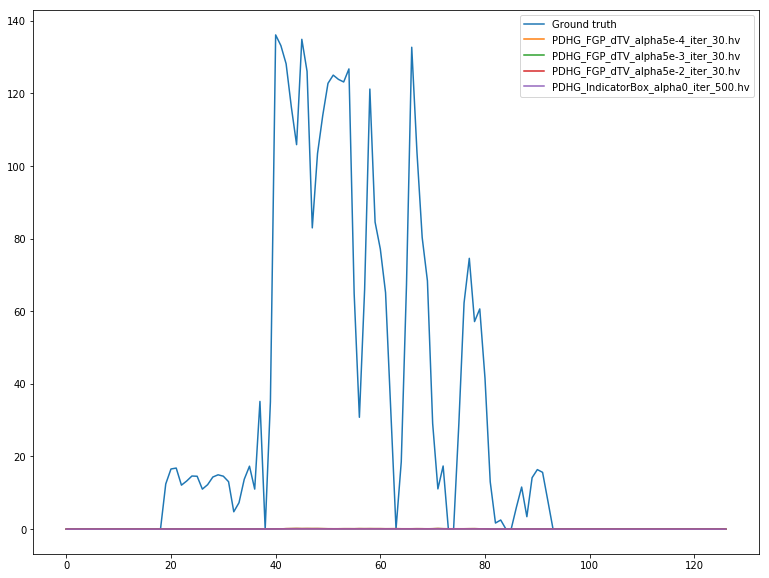

In [43]:
fig = plt.figure(figsize=(13,10))
for line , lab in zip(profiles, names):
    plt.plot(line, label=lab)
    plt.legend()
plt.show()

In [41]:
print (ground_truth.as_array().min(), ground_truth.as_array().max())

0.0 162.56111
